# Course Completion Prediction

**Latar Belakang**

Seiring dengan meningkatnya popularitas pendidikan online, institusi pendidikan dan platform e-learning mencari cara untuk meningkatkan tingkat penyelesaian kursus. Banyak peserta kursus online mengalami kesulitan untuk menyelesaikan kursus yang mereka ikuti, yang dapat disebabkan oleh berbagai faktor seperti motivasi, waktu, dan kesulitan materi. Mengetahui faktor-faktor yang mempengaruhi penyelesaian kursus dan dapat memprediksi peserta mana yang kemungkinan besar tidak akan menyelesaikan kursus sangat penting untuk merancang intervensi yang efektif.

**Tujuan Proyek**

Proyek ini bertujuan untuk membangun model machine learning yang dapat memprediksi apakah seorang peserta akan menyelesaikan kursus atau tidak berdasarkan berbagai fitur yang relevan. Dengan prediksi ini, platform e-learning dapat mengambil langkah proaktif untuk meningkatkan tingkat penyelesaian kursus, seperti memberikan dukungan tambahan kepada peserta yang berisiko.

**Business Understanding**

1. **Signifikansi Bisnis**

    Tingkat penyelesaian kursus yang rendah dapat mempengaruhi reputasi dan keberlanjutan platform e-learning. Dengan meningkatkan tingkat penyelesaian, platform dapat meningkatkan kepuasan dan retensi peserta, yang pada gilirannya dapat meningkatkan jumlah pendaftaran kursus dan pendapatan. Selain itu, peserta yang menyelesaikan kursus lebih cenderung merekomendasikan platform kepada orang lain, menciptakan efek word-of-mouth yang positif.

2. **Pemangku Kepentingan**

    Pemangku kepentingan utama dalam proyek ini meliputi:
    - Manajemen platform e-learning
    - Tim pengembangan produk
    - Instruktur dan pembuat konten kursus
    - Peserta kursus

**Data**

Dataset yang digunakan dalam proyek ini diambil dari Kaggle, dengan judul "Predict Online Course Engagement Dataset" yang dapat diakses di [sini](https://www.kaggle.com/datasets/rabieelkharoua/predict-online-course-engagement-dataset). Pada dataset tersebut terdapat 9000 baris dan 9 kolom, dengan kolom sebagai berikut:
- `UserID`: Identifikasi unik untuk setiap pengguna.
- `CourseCategory`: Kategori kursus yang diambil.
- `TimeSpentOnCourse`: Waktu yang dihabiskan peserta pada kursus dalam jam.
- `NumberOfVideosWatched`: Jumlah video yang ditonton oleh peserta.
- `NumberOfQuizzesTaken`: Jumlah kuis yang diambil oleh peserta.
- `QuizScores`: Rata-rata skor yang diperoleh peserta dari kuis.
- `CompletionRate`: Tingkat penyelesaian materi kursus.
- `DeviceType`: Jenis perangkat yang digunakan peserta untuk mengakses kursus (Dekstop (0) or Mobile (1)).
- `CourseCompletion`: Apakah peserta menyelesaikan kursus atau tidak (label target).


## Import libraries

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)

plt.style.use("ggplot")

In [5]:
RAW_DATA_PATH = "../data/raw/online_course_engagement_data.csv"

def load_course_completion(path):
    return pd.read_csv(path)

# Load the data 
df = load_course_completion(RAW_DATA_PATH)

In [9]:
df.head()

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,5618,Health,29.979719,17,3,50.365656,20.860773,1,0
1,4326,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,5849,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,4992,Science,35.038427,17,10,59.198853,95.433162,0,1
4,3866,Programming,92.490647,16,0,98.428285,18.102478,0,0


## Exploratory Data Analysis (EDA)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 9000 non-null   int64  
 1   CourseCategory         9000 non-null   object 
 2   TimeSpentOnCourse      9000 non-null   float64
 3   NumberOfVideosWatched  9000 non-null   int64  
 4   NumberOfQuizzesTaken   9000 non-null   int64  
 5   QuizScores             9000 non-null   float64
 6   CompletionRate         9000 non-null   float64
 7   DeviceType             9000 non-null   int64  
 8   CourseCompletion       9000 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 632.9+ KB


- Terdapat 9000 baris dalam dataset dengan 9 kolom/fitur
- Terdapat 1 fitur dengan tipe data object yaitu `CourseCategory`
- Terdapat 5 fitur dengan tipe data int (bilangan bulat) yaitu `UserID`, `TimeSpentOnCourse`, `NumberOfVideosWatched`, `NumberOfQuizzesTaken`, `DeviceType`, dan `CourseCompletion` (fitur target)
- Terdapat 3 fitur dengan tipe data float yaitu `TimeSpentOnCourse`, `QuizScores`, dan `CompletionRate`
- Tidak ada nilai `null`

In [13]:
# Check data duplicated
print(f"The number of data duplicated is {df.duplicated().sum()} data")

The number of data duplicated is 877 data


In [14]:
# Drop data duplicated
df = df.drop_duplicates().reset_index(drop=True)

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserID,8123.0,4504.687185,2604.220672,1.000000,2248.500000,4492.000000,6766.500000,9000.000000
TimeSpentOnCourse,8123.0,50.607728,28.364184,1.005230,26.114631,50.316921,75.377730,99.992558
NumberOfVideosWatched,8123.0,10.148098,5.987972,0.000000,5.000000,10.000000,15.000000,20.000000
NumberOfQuizzesTaken,8123.0,5.166933,3.132108,0.000000,2.000000,5.000000,8.000000,10.000000
QuizScores,8123.0,75.091084,14.339876,50.005119,62.791226,75.273913,87.497542,99.994984
CompletionRate,8123.0,51.190873,29.069716,0.009327,26.276765,51.581186,76.729629,99.979711
DeviceType,8123.0,0.500431,0.500031,0.000000,0.000000,1.000000,1.000000,1.000000
CourseCompletion,8123.0,0.439247,0.496326,0.000000,0.000000,0.000000,1.000000,1.000000


- Waktu (`TimeSpentOnCourse`): Rata-rata user menghabiskan waktu untuk menyelesaikan course sekitar 50 jam dengan nilai minimum 1 jam dan maksimum 99.99 (100) jam.
- Video (`NumberOfVideosWatched`): Rata-rata user menonton sebanyak 10 video dengan minimum 0 video dan maksimum 20 video.
- Kuis (`NumberOfQuizzesTaken`): Rata-rata user mengerjakan sebanyak 5 kuis dengan minimum 0 kuis dan maksimum 10 kuis.
- Skor Kuis (`QuizScores`): Rata-rata user mendapatkan skor kuis 75.
- Tingkat Penyelesaian (`CompletionRate`): Rata-rata user memiliki tingkat penyelesaian sebesar 51%.
- Device: Terdapat dua nilai yaitu 0 untuk pengguna Dekstop dan 1 untuk pengguna Mobile dengan proporsi masing-masing hampir 50%.
- `CourseCompletion`: Terdapat dua nilai yaitu 0 untuk yang tidak menyelesaikan course dan 1 untuk yang menyelesaikan course dengan proporsi sekitar 44% menyelesaikan course.

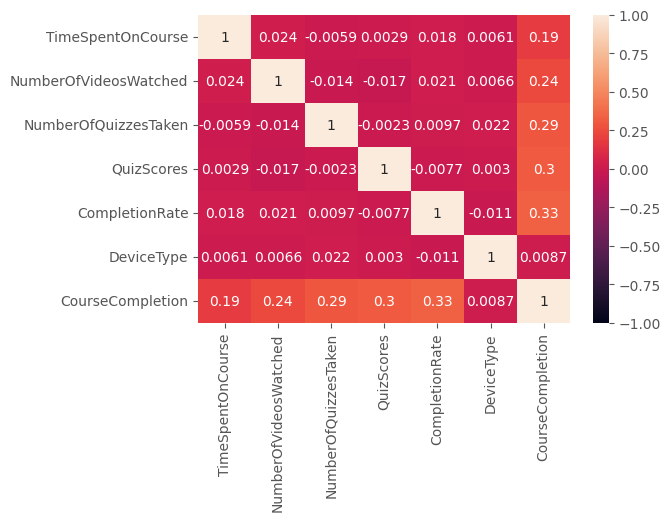

In [20]:
# Correlation
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1)
plt.show()

Top 5 korelasi dengan fitur target (`CourseCompletion`):
- `CompletionRate` (0.33)
- `QuizScores` (0.3)
- `NumberOfQuizzesTaken` (0.29)
- `NumberOfVideosWatched` (0.24)
- `TimeSpentOnCourse` (0.19)

Tidak ada fitur yang memiliki korelasi secara signifikan dengan fitur target

### Univariate Analysis

In [17]:
# Drop UserID column (to make it easier to analyze)
df = df.drop(columns="UserID", axis=1)

#### Numeric

**Asumsi**: `DeviceType` dan `CourseCompletion` dianggap categorical column karena hanya memiliki dua nilai klasifikasi

In [21]:
num_cols = [
    "TimeSpentOnCourse",
    "NumberOfVideosWatched",
    "NumberOfQuizzesTaken",
    "QuizScores",
    "CompletionRate",
]

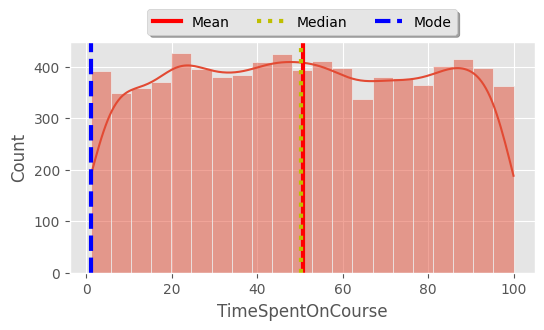

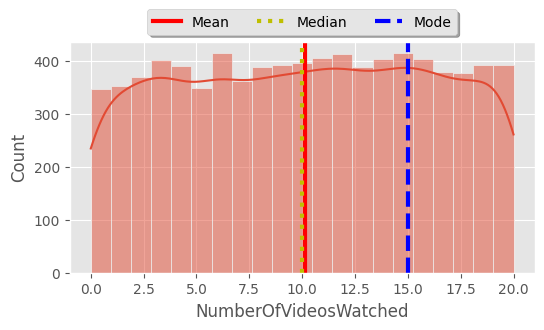

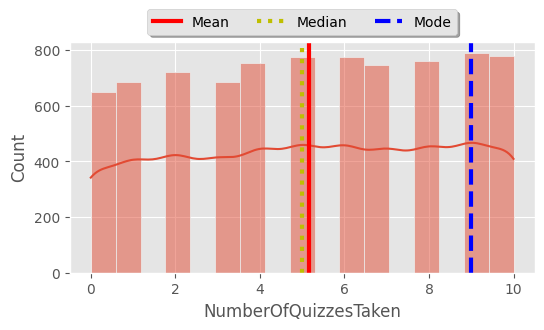

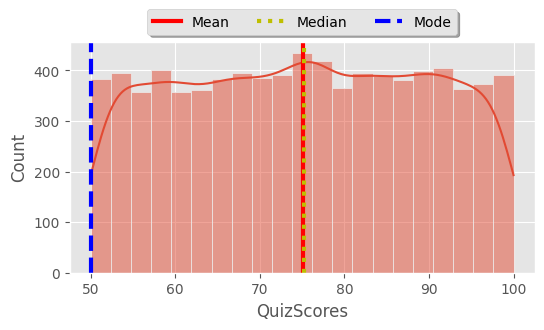

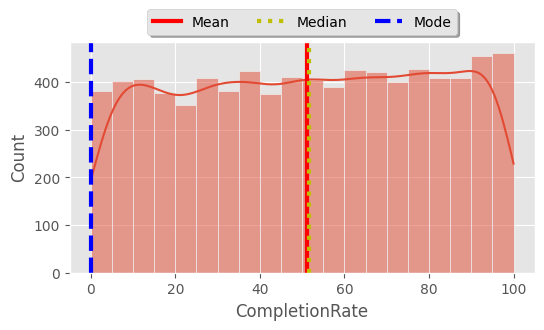

In [22]:
# Distribution of each numeric columns
for col in num_cols:
    # Statistic descriptive
    average = df[col].mean()
    median = df[col].median()
    mode = df[col].mode()[0]
    std = df[col].std()

    # Make subplot for histogram
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.histplot(data=df, x=col, kde=True)
    plt.axvline(average, color="r", linestyle="solid", linewidth=3, label="Mean")
    plt.axvline(median, color="y", linestyle="dotted", linewidth=3, label="Median")
    plt.axvline(mode, color="b", linestyle="dashed", linewidth=3, label="Mode")
    plt.legend(
        loc="upper center",
        ncol=3,
        bbox_to_anchor=(0.5, 1.17),
        fancybox=True,
        shadow=True,
    )
    plt.show()

Distribusi untuk masing-masing fitur numerik memiliki distribusi yang cukup merata, dengan nilai rata-rata (mean) yang selalu berimpit dengan nilali median. Dapat disimpulkan bahwa fitur-fitur numerik memiliki distribusi yang baik.

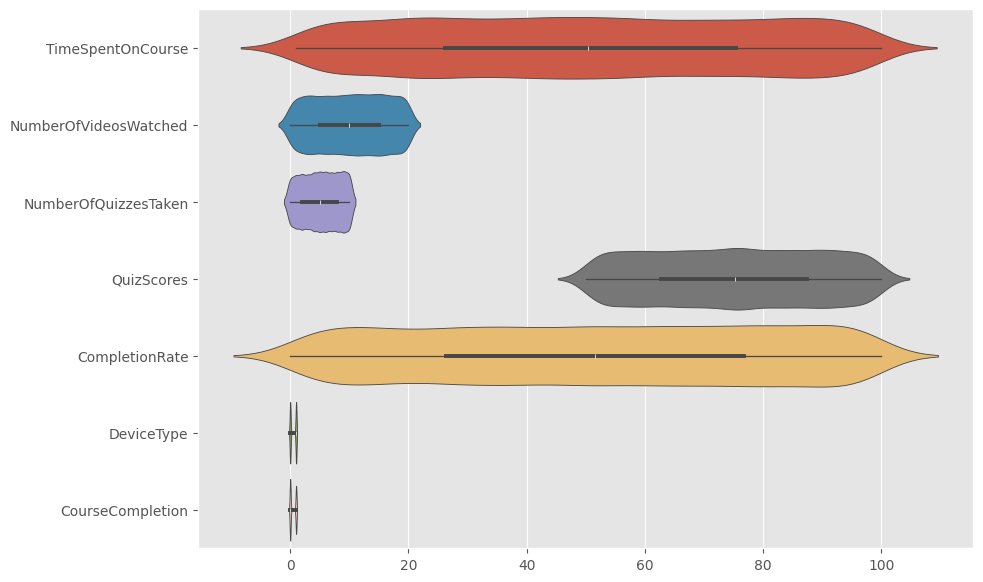

In [23]:
# Violin plot for numeric columns
plt.figure(figsize=(10, 7))
sns.violinplot(data=df, orient="y")
plt.show()

Berdasarkan violinplot tersebut, terlihat bahwa data terdistribusi dengan baik dan tidak memiliki outlier.

#### Categorical

In [24]:
cat_cols = ["CourseCategory", "DeviceType", "CourseCompletion"]

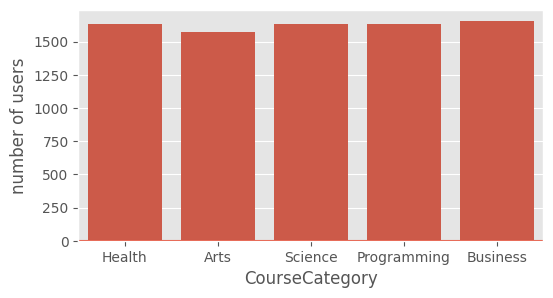

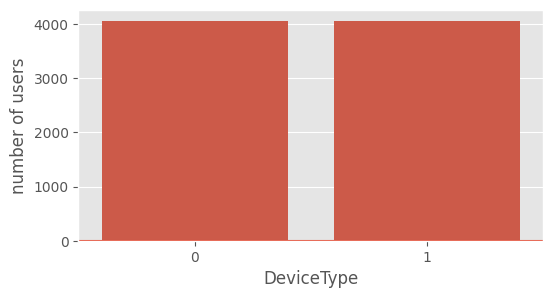

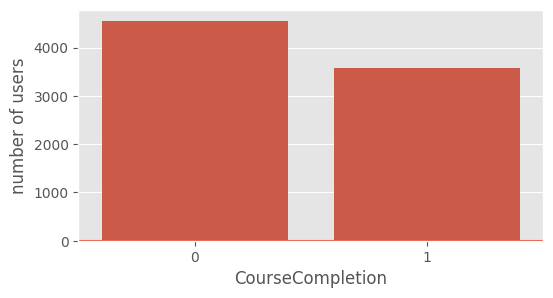

In [25]:
# Barchart plot for categorical columns
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.countplot(data=df, x=col)
    plt.axhline()
    plt.ylabel("number of users")
    plt.show()

In [30]:
df["CourseCompletion"].value_counts() / len(df)

CourseCompletion
0    0.560753
1    0.439247
Name: count, dtype: float64

Berdasarkan barplot pada fitur-fitur kategorikal tersebut, terlihat bahwa fitur-fitur tersebut memiliki distribusi yang baik. Pada `CourseCategory`, nilai *Arts* menjadi nilai yang paling sedikit, pada `DeviceType` memiliki proporsi nilai dengan selisih sedikit. Sedangkan pada `CourseCompletion` memiliki proporsi sekitar 56.07% untuk nilai 0 dan 43.92% untuk nilai 1.

### Bivariate Analysis

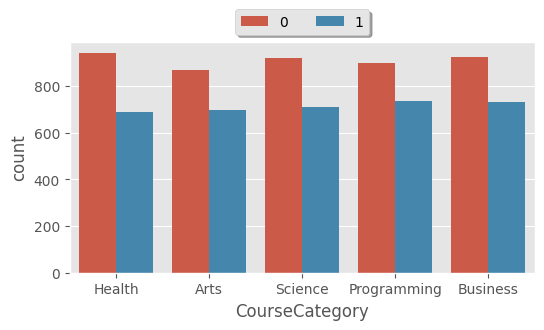

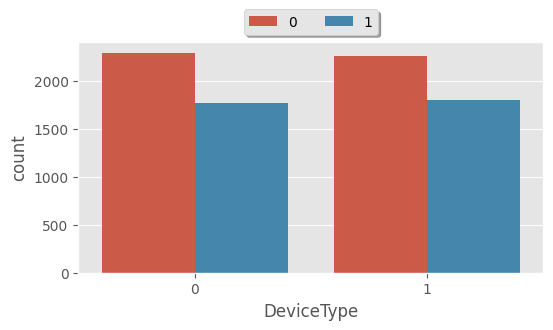

In [31]:
# Number of CourseCategory and DeviceType by CouseCompletion
for col in ["CourseCategory", "DeviceType"]:
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue="CourseCompletion")
    plt.legend(
        loc="upper center",
        ncol=2,
        bbox_to_anchor=[0.5, 1.17],
        fancybox=True,
        shadow=True,
    )
    plt.show()